In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from WindPy import w
%matplotlib inline

In [2]:
sns.set_style("darkgrid")

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
DATA_DIR = "C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/"
STOCK_FILE = "%s/stock.xlsx"%(DATA_DIR)
BOND_FILE = "%s/bond.xlsx"%(DATA_DIR)
HK_FILE = "%s/hk.xlsx"%(DATA_DIR)
START_DATE = "2005-01-01"
END_DATE = "2016-12-31"

In [5]:
stock_df = pd.read_excel(STOCK_FILE)

In [6]:
stock_df.set_index('code', inplace=True)

In [7]:
stock_df

,name
code,
CI005001.WI,石油石化
CI005002.WI,煤炭
CI005003.WI,有色金属
CI005004.WI,电力及公用事业
CI005005.WI,钢铁
CI005006.WI,基础化工
CI005007.WI,建筑
CI005008.WI,建材
CI005009.WI,轻工制造


In [8]:
bond_df = pd.read_excel(BOND_FILE)

In [9]:
bond_df.set_index('code', inplace=True)

In [10]:
bond_df

,name
code,
038.CS,中债国债
042.CS,中债金融债券
078.CS,中债企业债AAA
079.CS,中债企业债AA+
080.CS,中债企业债AA
081.CS,中债企业债AA-
053.CS,中债短融
H11025.CSI,货币基金
098.CS,中债银行间资产支持证券


In [11]:
hk_df = pd.read_excel(HK_FILE)

In [12]:
hk_df.set_index('code', inplace=True)

In [13]:
hk_df

,name
code,
HSESI.HI,恒生能源业
HSCIMT.HI,恒生原材料业
HSGSI.HI,恒生工业
HSCISV.HI,恒生消费者服务业
HSTSI.HI,恒生电讯业
HSUSI.HI,恒生公用事业
HSFSI.HI,恒生金融业
HSPCSI.HI,恒生地产建筑业
HSITSI.HI,恒生资讯科技业


In [14]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [15]:
def get_ranks(asset_df, groups=5):
    length = asset_df.shape[0]
    leng_group = length / groups
    if length % groups > groups / 2:
        leng_group += 1
    ranks = []
    for i in range(1, groups):
        ranks += [i]*leng_group
    ranks += [groups]*(length-len(ranks))
    return ranks

In [16]:
def get_asset_return(asset_df, frequency="y"):
    res_df = asset_df.copy()
    for asset in asset_df.index:
        data = w.wsd(asset, 'close', START_DATE, END_DATE)
        df = wind2df(data)
        if frequency == "y":
            df = df.resample('A').last()
        elif frequency == "m":
            df = df.resample('M').last()
        df['return'] = df['close'].pct_change()
        for ind in df.index[1:]:
            if frequency == "y":
                year = ind.year
                res_df.loc[asset, "%d return"%(year)] = df.loc[ind, 'return']
            elif frequency == "m":
                year, month = ind.year, ind.month
                res_df.loc[asset, "%d-%d return"%(year, month)] = df.loc[ind, 'return']
    return res_df

In [17]:
def get_factor(asset_df, factor, frequency='y', order=False, relative=True):
    """
    order为False数值越小得分越高，反之越大得分越高
    """
    res_df = asset_df.copy()
    for asset in asset_df.index:
        data = w.wsd(asset, factor, START_DATE, END_DATE)
        df = wind2df(data)
        if frequency == "y":
            df = df.resample('A').last()
        elif frequency == "m":
            df = df.resample('M').last()
            
        for i, ind in enumerate(df.index[:-1]):
            next_ind = df.index[i+1]
            if frequency == "y":
                year = next_ind.year
                col_name = "%d %s"%(year, factor)
            elif frequency == "m":
                year, month = next_ind.year, next_ind.month
                col_name = "%d-%d %s"%(year, month, factor)

            if relative:
                factor_value = df.loc[ind, factor] # 与其他asset相比
            else:
                factor_value = df[df.index <= ind][factor].rank(pct=True).iloc[-1] # 历史分位，与自己过去相比
                
            if not order:
                res_df.loc[asset, col_name] = factor_value
            else:
                res_df.loc[asset, col_name] = factor_value * -1.0
    return res_df

In [18]:
def get_group_return(asset_df, factors, weights, ranks):
    assert(len(factors) == len(weights))
    weights = np.array(weights) * 1.0 / sum(weights)
    ranks = np.array(ranks)
    groups = max(ranks)
    group_df = pd.DataFrame(index=range(1, groups+1))
    freqs = set([f.split(' ')[0] for f in stock_df.columns if f.find(' ') != -1])
    for freq in freqs:
        features = ["%s %s"%(freq, f) for f in factors]
        rcol = "%s return"%(freq)
        features.append(rcol)
        df = asset_df[features]
        for f, w in zip(factors, weights):
            df = df.sort_values(by="%s %s"%(freq, f), ascending=False) # 值越小越有价值
            df["%s rank"%(f)] = ranks * w
            
        features = ["%s rank"%(f) for f in factors]
        df["sum rank"] = df[features].sum(axis=1)
        df = df.sort_values(by="sum rank", ascending=True)
        df["rank"] = ranks
        
        group_df[rcol] = df.groupby('rank').mean()[rcol]
    return group_df

# Verification

In [357]:
code = "300104.SZ"
freq = 'BM'
factor = "pe_ttm"
look_back = 1

In [358]:
data = w.wsd(code, 'close', START_DATE, END_DATE)
price = wind2df(data)
price = price.resample(freq).last()
price['return'] = price['close'].pct_change()

In [359]:
data = w.wsd(code, factor, START_DATE, END_DATE)
pe_df = wind2df(data)
pe_df = pe_df.resample(freq).last()
price[factor] = pe_df[factor]

In [360]:
price["%s shift"%(factor)] = price[factor].shift(look_back) # 用pe预测下期收益率

### 当前value在历史value中的percentile

In [361]:
price['percentile'] = np.nan
for index in price.index:
    price.ix[index, 'percentile'] = price[price.index <= index]['%s shift'%(factor)].rank(pct=True).iloc[-1]

### 当前value在最近x个月value中的percentile

In [362]:
def rank_percentile(array):
    s = pd.Series(array)
    s = s.rank(pct=True)
    return s.iloc[-1]

In [363]:
price["%s percentile"%(factor)] = price["%s shift"%(factor)].rolling(window=24).apply(rank_percentile)

In [364]:
df = price[price.index >= "2010-01-01"]

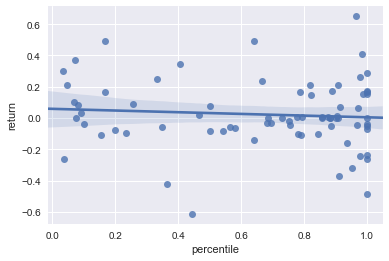

In [365]:
ax = sns.regplot(x="percentile", y='return', data=df)

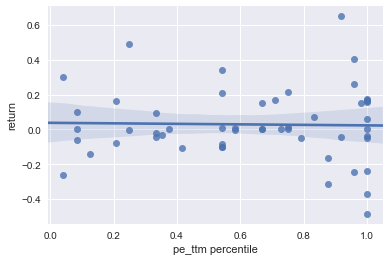

In [366]:
ax = sns.regplot(x="%s percentile"%(factor), y='return', data=df)

# 添加各指数每年的收益率

In [369]:
stock_df = get_asset_return(stock_df, 'm')

In [370]:
stock_df

,name,2005-2 return,2005-3 return,2005-4 return,2005-5 return,2005-6 return,2005-7 return,2005-8 return,2005-9 return,2005-10 return,...,2016-3 return,2016-4 return,2016-5 return,2016-6 return,2016-7 return,2016-8 return,2016-9 return,2016-10 return,2016-11 return,2016-12 return
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.119650,-0.082533,-0.019008,-0.107732,0.021315,0.031912,0.117113,-0.008703,-0.063099,...,0.118403,0.008103,-0.034639,0.002035,0.026168,0.039641,-0.012184,0.027873,0.045451,0.037266
CI005002.WI,煤炭,0.130761,-0.107633,0.015134,-0.132142,-0.075732,-0.041931,0.015111,0.043744,-0.116103,...,0.033785,0.069521,-0.105413,0.030836,0.040685,0.053560,0.004254,0.085985,-0.007452,-0.065356
CI005003.WI,有色金属,0.141099,-0.111822,-0.017263,-0.099106,0.005148,-0.042460,0.106784,0.064712,-0.075181,...,0.159006,0.005368,0.001784,0.055527,-0.006229,0.006572,-0.049989,0.052947,0.045375,-0.069392
CI005004.WI,电力及公用事业,0.078857,-0.088172,-0.009859,-0.063934,0.051293,-0.002562,0.025017,-0.009448,-0.071457,...,0.130250,-0.025848,-0.015604,0.015744,0.030326,0.054272,-0.017153,0.026628,0.025408,-0.047794
CI005005.WI,钢铁,0.074207,-0.097204,-0.101365,-0.048186,0.030876,0.013474,-0.014439,-0.031527,-0.052417,...,0.092624,0.013319,-0.044245,-0.002995,-0.001621,0.084700,-0.008191,0.058812,0.064904,-0.022715
CI005006.WI,基础化工,0.107023,-0.068936,-0.004672,-0.110753,0.006115,-0.053495,0.108957,0.022842,-0.045237,...,0.196678,-0.007828,-0.021591,0.067368,0.012429,0.044019,-0.006564,0.031222,0.022393,-0.022381
CI005007.WI,建筑,0.114503,-0.146377,-0.062489,-0.037497,0.007579,-0.104863,0.151029,0.017761,-0.056612,...,0.173414,-0.035268,-0.034536,0.012411,0.018386,0.101992,-0.022918,0.084745,0.142655,-0.082625
CI005008.WI,建材,0.099195,-0.138937,-0.106926,-0.032051,-0.007706,-0.062991,0.148838,0.039524,-0.024497,...,0.193442,-0.009168,-0.035084,0.038567,0.020345,0.064250,0.009116,0.035661,0.022783,-0.036397
CI005009.WI,轻工制造,0.067891,-0.117231,-0.039307,-0.036816,0.000464,-0.028363,0.040143,0.002194,-0.090822,...,0.187101,-0.012159,-0.026559,0.039962,0.018280,0.043118,0.005232,0.028179,0.020264,-0.037901


# book-to-price

In [371]:
book_to_price = "pb_lf"

In [372]:
stock_df = get_factor(stock_df, book_to_price, frequency='m', relative=False)

In [373]:
stock_df.head()

,name,2005-2 return,2005-3 return,2005-4 return,2005-5 return,2005-6 return,2005-7 return,2005-8 return,2005-9 return,2005-10 return,...,2016-3 pb_lf,2016-4 pb_lf,2016-5 pb_lf,2016-6 pb_lf,2016-7 pb_lf,2016-8 pb_lf,2016-9 pb_lf,2016-10 pb_lf,2016-11 pb_lf,2016-12 pb_lf
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.119650,-0.082533,-0.019008,-0.107732,0.021315,0.031912,0.117113,-0.008703,-0.063099,...,0.007463,0.022222,0.022059,0.021898,0.021739,0.028777,0.050000,0.035461,0.049296,0.083916
CI005002.WI,煤炭,0.130761,-0.107633,0.015134,-0.132142,-0.075732,-0.041931,0.015111,0.043744,-0.116103,...,0.074627,0.103704,0.165441,0.102190,0.123188,0.194245,0.221429,0.226950,0.246479,0.244755
CI005003.WI,有色金属,0.141099,-0.111822,-0.017263,-0.099106,0.005148,-0.042460,0.106784,0.064712,-0.075181,...,0.291045,0.400000,0.448529,0.445255,0.500000,0.546763,0.535714,0.460993,0.542254,0.594406
CI005004.WI,电力及公用事业,0.078857,-0.088172,-0.009859,-0.063934,0.051293,-0.002562,0.025017,-0.009448,-0.071457,...,0.373134,0.518519,0.455882,0.437956,0.463768,0.489209,0.507143,0.531915,0.521127,0.545455
CI005005.WI,钢铁,0.074207,-0.097204,-0.101365,-0.048186,0.030876,0.013474,-0.014439,-0.031527,-0.052417,...,0.477612,0.525926,0.617647,0.569343,0.521739,0.582734,0.642857,0.631206,0.690141,0.748252


# earnings-to-price

In [374]:
earnings_to_price = "pe_ttm"

In [375]:
stock_df = get_factor(stock_df, earnings_to_price, frequency='m', relative=False)

In [376]:
stock_df.head()

,name,2005-2 return,2005-3 return,2005-4 return,2005-5 return,2005-6 return,2005-7 return,2005-8 return,2005-9 return,2005-10 return,...,2016-3 pe_ttm,2016-4 pe_ttm,2016-5 pe_ttm,2016-6 pe_ttm,2016-7 pe_ttm,2016-8 pe_ttm,2016-9 pe_ttm,2016-10 pe_ttm,2016-11 pe_ttm,2016-12 pe_ttm
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.119650,-0.082533,-0.019008,-0.107732,0.021315,0.031912,0.117113,-0.008703,-0.063099,...,0.932836,0.933333,0.985294,0.970803,0.956522,0.956835,1.000000,0.992908,0.985915,0.986014
CI005002.WI,煤炭,0.130761,-0.107633,0.015134,-0.132142,-0.075732,-0.041931,0.015111,0.043744,-0.116103,...,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.978102,0.971014
CI005003.WI,有色金属,0.141099,-0.111822,-0.017263,-0.099106,0.005148,-0.042460,0.106784,0.064712,-0.075181,...,NaN,0.902439,0.967742,0.952000,0.952381,0.952756,0.906250,0.899225,0.853846,0.854962
CI005004.WI,电力及公用事业,0.078857,-0.088172,-0.009859,-0.063934,0.051293,-0.002562,0.025017,-0.009448,-0.071457,...,0.152672,0.242424,0.300752,0.305970,0.325926,0.352941,0.423358,0.420290,0.467626,0.507143
CI005005.WI,钢铁,0.074207,-0.097204,-0.101365,-0.048186,0.030876,0.013474,-0.014439,-0.031527,-0.052417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# cash flow-to-price

In [377]:
cashflow_to_price = "pcf_ocf_ttm"

In [378]:
stock_df = get_factor(stock_df, cashflow_to_price, frequency='m', relative=False)

In [379]:
stock_df.head()

,name,2005-2 return,2005-3 return,2005-4 return,2005-5 return,2005-6 return,2005-7 return,2005-8 return,2005-9 return,2005-10 return,...,2016-3 pcf_ocf_ttm,2016-4 pcf_ocf_ttm,2016-5 pcf_ocf_ttm,2016-6 pcf_ocf_ttm,2016-7 pcf_ocf_ttm,2016-8 pcf_ocf_ttm,2016-9 pcf_ocf_ttm,2016-10 pcf_ocf_ttm,2016-11 pcf_ocf_ttm,2016-12 pcf_ocf_ttm
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.119650,-0.082533,-0.019008,-0.107732,0.021315,0.031912,0.117113,-0.008703,-0.063099,...,0.029851,0.200000,0.036765,0.029197,0.021739,0.035971,0.221429,0.170213,0.218310,0.286713
CI005002.WI,煤炭,0.130761,-0.107633,0.015134,-0.132142,-0.075732,-0.041931,0.015111,0.043744,-0.116103,...,0.835821,0.637037,0.536765,0.335766,0.427536,0.503597,0.492857,0.503546,0.154930,0.139860
CI005003.WI,有色金属,0.141099,-0.111822,-0.017263,-0.099106,0.005148,-0.042460,0.106784,0.064712,-0.075181,...,0.343284,0.474074,0.448529,0.510949,0.550725,0.553957,0.621429,0.581560,0.521127,0.559441
CI005004.WI,电力及公用事业,0.078857,-0.088172,-0.009859,-0.063934,0.051293,-0.002562,0.025017,-0.009448,-0.071457,...,0.238806,0.311111,0.323529,0.313869,0.333333,0.366906,0.450000,0.425532,0.464789,0.482517
CI005005.WI,钢铁,0.074207,-0.097204,-0.101365,-0.048186,0.030876,0.013474,-0.014439,-0.031527,-0.052417,...,0.604478,0.666667,0.661765,0.656934,0.644928,0.683453,0.571429,0.567376,0.514085,0.580420


# sales-to-enterprise value

In [380]:
sales_to_enterprise = "ps_ttm"

In [381]:
stock_df = get_factor(stock_df, sales_to_enterprise, frequency='m', relative=False)

In [382]:
stock_df.head()

,name,2005-2 return,2005-3 return,2005-4 return,2005-5 return,2005-6 return,2005-7 return,2005-8 return,2005-9 return,2005-10 return,...,2016-3 ps_ttm,2016-4 ps_ttm,2016-5 ps_ttm,2016-6 ps_ttm,2016-7 ps_ttm,2016-8 ps_ttm,2016-9 ps_ttm,2016-10 ps_ttm,2016-11 ps_ttm,2016-12 ps_ttm
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.119650,-0.082533,-0.019008,-0.107732,0.021315,0.031912,0.117113,-0.008703,-0.063099,...,0.223881,0.370370,0.397059,0.386861,0.340580,0.366906,0.492857,0.460993,0.500000,0.531469
CI005002.WI,煤炭,0.130761,-0.107633,0.015134,-0.132142,-0.075732,-0.041931,0.015111,0.043744,-0.116103,...,0.231343,0.259259,0.360294,0.306569,0.340580,0.395683,0.464286,0.468085,0.492958,0.482517
CI005003.WI,有色金属,0.141099,-0.111822,-0.017263,-0.099106,0.005148,-0.042460,0.106784,0.064712,-0.075181,...,0.283582,0.429630,0.455882,0.452555,0.543478,0.561151,0.578571,0.524823,0.584507,0.615385
CI005004.WI,电力及公用事业,0.078857,-0.088172,-0.009859,-0.063934,0.051293,-0.002562,0.025017,-0.009448,-0.071457,...,0.582090,0.711111,0.713235,0.700730,0.717391,0.733813,0.778571,0.744681,0.767606,0.804196
CI005005.WI,钢铁,0.074207,-0.097204,-0.101365,-0.048186,0.030876,0.013474,-0.014439,-0.031527,-0.052417,...,0.656716,0.725926,0.794118,0.751825,0.746377,0.791367,0.821429,0.808511,0.823944,0.860140


# 获取每年分组后的收益

In [467]:
ranks = get_ranks(stock_df)

In [532]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise]
# factors = [book_to_price]
weights = [1, 1, 1, 1]

In [533]:
group_df = get_group_return(stock_df, factors, weights, ranks)

In [534]:
group_df

,2007-8 return,2007-9 return,2007-4 return,2007-5 return,2007-6 return,2007-7 return,2007-1 return,2007-2 return,2007-3 return,2015-11 return,...,2009-11 return,2009-12 return,2008-4 return,2013-7 return,2013-6 return,2008-9 return,2008-8 return,2013-3 return,2013-2 return,2013-1 return
1,0.162215,0.121460,0.321360,0.093495,-0.091048,0.214681,0.129834,0.084178,0.115842,0.067134,...,0.106355,0.035703,0.041690,0.124017,-0.122927,-0.048474,-0.227693,-0.020864,0.031979,0.065365
2,0.128332,0.011157,0.274177,0.099989,-0.100572,0.180871,0.218433,0.092606,0.103999,0.088111,...,0.107629,0.025601,0.010904,0.054842,-0.146205,-0.044375,-0.209822,-0.049309,0.035253,0.041543
3,0.095823,0.026669,0.313499,0.078728,-0.126444,0.174065,0.261319,0.136507,0.150662,0.072049,...,0.133486,0.022527,-0.032743,0.034964,-0.170812,-0.048834,-0.211509,-0.040372,0.010872,0.045670
4,0.145690,0.044954,0.331829,0.123480,-0.095517,0.179329,0.240633,0.161675,0.148142,0.048227,...,0.145148,0.019494,-0.011289,0.032085,-0.161689,-0.047483,-0.205561,-0.052274,0.019819,0.059832
5,0.138935,0.049154,0.287528,0.046886,-0.039842,0.179451,0.227735,0.139802,0.074110,0.039330,...,0.071743,0.047813,0.062046,-0.015972,-0.155271,-0.048415,-0.170038,-0.041352,0.015338,0.104256


In [538]:
start_year = 2016
year_feature = []
for year in range(start_year, 2017):
    year_feature += ["%d-%d return"%(year, month) for month in range(1, 13)]

In [539]:
res = group_df[year_feature].mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

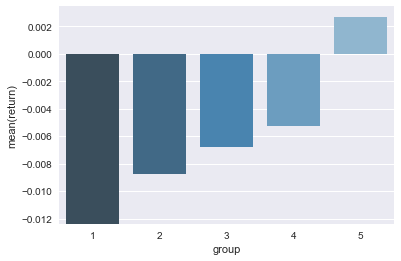

In [540]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [390]:
group_df.to_excel("%s/value.xlsx"%(DATA_DIR))

# 加入momentum

In [410]:
for stock in stock_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
#     df = df.resample('BMS').first()
    df['return'] = df.pct_change()
    df['avg return'] = df['return'].rolling(window=30).mean()
    df = df.resample('M').last()
    for i, ind in enumerate(df.index[:-1]):
        year, month = df.index[i+1].year, df.index[i+1].month
        stock_df.loc[stock, "%d-%d momentum"%(year, month)] = -df.loc[ind, "avg return"]

In [523]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum"]
weights = [1, 1, 1, 1, 4]

In [524]:
ranks = get_ranks(stock_df)

In [525]:
group_df = get_group_return(stock_df, factors, weights, ranks)

In [526]:
group_df

,2007-8 return,2007-9 return,2007-4 return,2007-5 return,2007-6 return,2007-7 return,2007-1 return,2007-2 return,2007-3 return,2015-11 return,...,2009-11 return,2009-12 return,2008-4 return,2013-7 return,2013-6 return,2008-9 return,2008-8 return,2013-3 return,2013-2 return,2013-1 return
1,0.079119,0.023300,0.267878,0.109945,-0.084093,0.179187,0.273779,0.112932,0.093266,0.030727,...,0.133405,0.012931,0.043043,0.044618,-0.180848,-0.056148,-0.218865,-0.060526,0.006212,0.055890
2,0.126289,0.035198,0.284179,0.051494,-0.065923,0.187674,0.233509,0.101828,0.103363,0.062356,...,0.109060,0.007155,-0.021413,0.024885,-0.165403,-0.037416,-0.193420,-0.052302,0.024126,0.053136
3,0.131586,0.048729,0.285039,0.119902,-0.107176,0.175887,0.168984,0.141403,0.118212,0.057041,...,0.111254,0.049389,0.077003,0.077624,-0.146301,-0.016440,-0.171524,-0.028869,0.015672,0.062253
4,0.113047,0.066427,0.315114,0.118494,-0.093031,0.191405,0.221890,0.156001,0.137148,0.065418,...,0.136985,0.043726,0.018006,0.063539,-0.121822,-0.074888,-0.213351,-0.014512,0.047562,0.045250
5,0.237357,0.085858,0.393914,0.041913,-0.115871,0.197204,0.170204,0.095165,0.154097,0.111304,...,0.074040,0.035961,-0.067646,0.026319,-0.139981,-0.053543,-0.238948,-0.049284,0.020558,0.099315


In [527]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

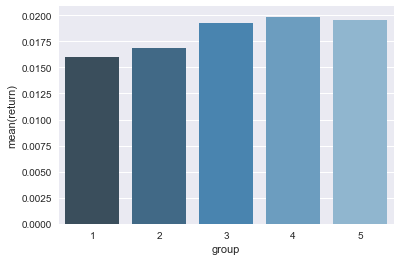

In [528]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [529]:
start_year = 2016
year_feature = []
for year in range(start_year, 2017):
    year_feature += ["%d-%d return"%(year, month) for month in range(1, 13)]

In [530]:
res = group_df[year_feature].mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

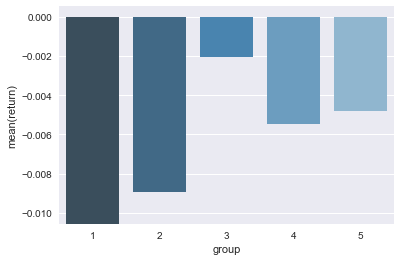

In [531]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [54]:
group_df.to_excel("%s/value_momentum.xlsx"%(DATA_DIR))

# 加入波动率

In [504]:
for stock in stock_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df['return'] = df.pct_change()
    df['volatility'] = df['return'].rolling(window=243).std() * np.sqrt(243)
    df = df.resample('M').first()
    for i, ind in enumerate(df.index[:-1]):
        year, month = df.index[i+1].year, df.index[i+1].month
        stock_df.loc[stock, "%d-%d volatility"%(year, month)] = df.loc[ind, "volatility"]

In [505]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum", "volatility"]
weights = [1, 1, 1, 1, 4, 4]

In [510]:
ranks = get_ranks(stock_df)

In [511]:
group_df = get_group_return(stock_df, factors, weights, ranks)

In [512]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

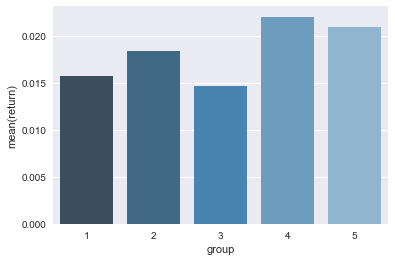

In [513]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [520]:
start_year = 2016
year_feature = []
for year in range(start_year, 2017):
    year_feature += ["%d-%d return"%(year, month) for month in range(1, 13)]

In [521]:
res = group_df[year_feature].mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

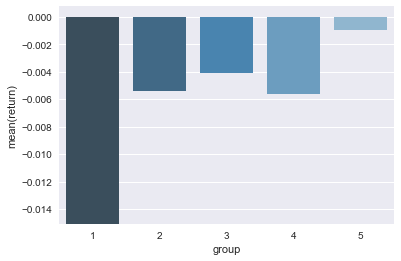

In [522]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [541]:
group_df.to_excel("%s/value_momentum_volatility.xlsx"%(DATA_DIR))

# 尝试港股

In [55]:
hk_df = get_asset_return(hk_df)

In [56]:
hk_df = get_factor(hk_df, book_to_price)

In [57]:
hk_df = get_factor(hk_df, earnings_to_price)

In [58]:
hk_df = get_factor(hk_df, cashflow_to_price)

In [59]:
hk_df = get_factor(hk_df, sales_to_enterprise)

In [60]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise]
weights = [1, 1, 1, 1]

In [61]:
ranks = get_ranks(hk_df)

In [63]:
group_df = get_group_return(hk_df, factors, weights, years, ranks)

In [64]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,0.744535,0.214120,-0.572021,0.368132,0.011486,-0.214144,0.233222,0.269726,-0.108203,0.060267,0.058958
2,0.145912,0.481753,-0.583149,0.559339,0.078963,-0.226198,0.169787,0.405917,-0.024344,-0.160272,-0.019107
3,0.499137,0.471149,-0.520250,1.411913,0.142432,-0.435526,0.196006,-0.100526,0.062867,-0.009524,-0.067866
4,0.391787,0.503196,-0.557549,0.751840,0.148867,-0.113068,0.198174,0.017316,0.029287,-0.075689,-0.092508
5,0.373656,0.453564,-0.456744,0.821676,0.169209,-0.129451,0.209667,-0.076393,-0.051277,-0.175240,0.111510


In [67]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

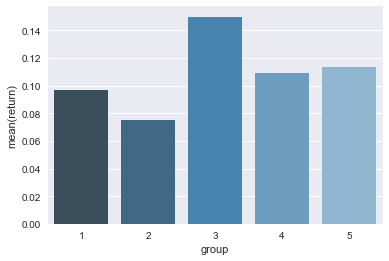

In [69]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [70]:
group_df.to_excel("%s/hk_value.xlsx"%(DATA_DIR))

In [71]:
for stock in hk_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df = df.resample('BMS').first()
    df['return'] = df.pct_change()
    df['avg return'] = df['return'].rolling(window=12).mean()
    df = df.resample('BAS').first()
    for ind in df.index[1:]:
        year = ind.year
        hk_df.loc[stock, "%d momentum"%(year)] = -df.loc[ind, "avg return"]

In [72]:
ranks = get_ranks(hk_df)

In [73]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum"]
weights = [1, 1, 1, 1, 4]

In [74]:
group_df = get_group_return(hk_df, factors, weights, years, ranks)

In [75]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

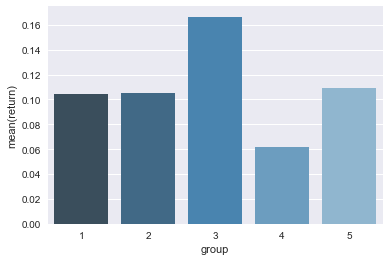

In [76]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

# 尝试债券

In [542]:
bond_df = get_asset_return(bond_df, frequency='m')

In [552]:
for bond in bond_df.index:
    data = w.wsd(bond, 'ytm_b', START_DATE, END_DATE, "returnType=1")
    df = wind2df(data)
    df = df.resample('M').last()
    for i, ind in enumerate(df.index[:-1]):
        year, month = df.index[i+1].year, df.index[i+1].month
        if df.loc[ind, "ytm_b"] == None:
            bond_df.loc[bond, "%d-%d %s"%(year, month, "ytm_b")] = df.loc[ind, "ytm_b"]
        else:
            bond_df.loc[bond, "%d-%d %s"%(year, month, "ytm_b")] = df.loc[ind, "ytm_b"] * -1.0

In [553]:
factors = ["ytm_b"]
weights = [1]

In [554]:
ranks = get_ranks(bond_df)

In [555]:
group_df = get_group_return(bond_df, factors, weights, ranks)

In [556]:
group_df

,2007-8 return,2007-9 return,2007-4 return,2007-5 return,2007-6 return,2007-7 return,2007-1 return,2007-2 return,2007-3 return,2015-11 return,...,2009-11 return,2009-12 return,2008-4 return,2013-7 return,2013-6 return,2008-9 return,2008-8 return,2013-3 return,2013-2 return,2013-1 return
1,0.003499,-0.001404,-0.001262,-0.005428,-0.005097,0.004649,0.003071,0.001173,-0.000069,0.001083,...,0.002227,0.002239,0.001654,-0.005522,-0.003253,0.021375,0.010576,0.003631,0.003297,0.004325
2,0.005498,-0.005633,-0.001543,-0.002164,-0.023448,-0.011292,0.002672,0.001595,-0.001575,0.000557,...,0.009224,0.006044,0.002698,0.001194,-0.003415,0.035516,0.009264,0.003571,0.006131,0.006994
3,0.001694,-0.010224,-0.001138,-0.014864,-0.034063,-0.011557,NaN,0.004444,-0.001480,-0.001145,...,0.007553,0.011557,0.004581,-0.002892,-0.002357,0.048877,0.005802,0.004278,0.010139,0.011636
4,0.002578,-0.002349,0.001166,-0.004457,-0.023407,-0.006356,0.001953,0.002213,0.000822,0.000501,...,0.003860,0.006690,0.003688,0.000744,0.000979,0.023893,0.005836,0.004000,0.007065,0.007493
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [558]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

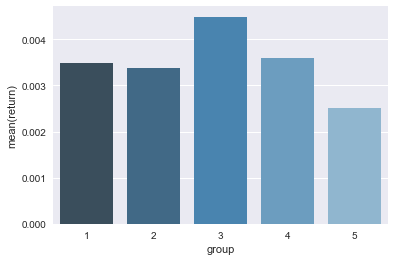

In [559]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [569]:
start_year = 2012
year_feature = []
for year in range(start_year, 2017):
    year_feature += ["%d-%d return"%(year, month) for month in range(1, 13)]

In [570]:
res = group_df[year_feature].mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

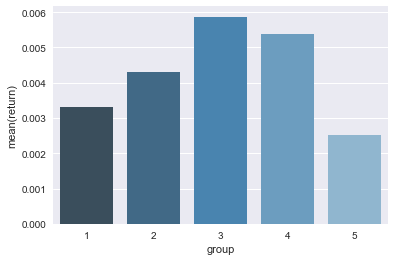

In [571]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [94]:
group_df.to_excel("%s/bond_value.xlsx"%(DATA_DIR))

# 尝试某一行业

In [587]:
ind_df = pd.read_excel(u"%s/CS家电.xlsx"%(DATA_DIR))

In [588]:
ind_df.drop(ind_df.index[-2:], inplace=True)

In [589]:
ind_df.set_index('code', inplace=True)

In [590]:
ind_df = get_asset_return(ind_df, frequency='m')

In [592]:
ind_df = get_factor(ind_df, book_to_price, frequency='m')

In [594]:
ind_df = get_factor(ind_df, earnings_to_price, frequency='m')

In [620]:
ind_df = get_factor(ind_df, cashflow_to_price, frequency='m')

In [621]:
ind_df = get_factor(ind_df, sales_to_enterprise, frequency='m')

In [634]:
for stock in ind_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df['return'] = df.pct_change()
    df['avg return'] = df['return'].rolling(window=30).mean()
    df = df.resample('M').first()
    for i, ind in enumerate(df.index[:-1]):
        year, month = df.index[i+1].year, df.index[i+1].month
        ind_df.loc[stock, "%d-%d momentum"%(year, month)] = -df.loc[ind, "avg return"]

                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                              outmessage  return  avg return
2017-03-31  CWSDService: quota exceeded.     NaN         NaN
                        

In [624]:
ind_df = ind_df.dropna()

In [629]:
ranks = get_ranks(ind_df)

In [630]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum"]
weights = [1, 1, 1, 1, 4]

In [631]:
group_df = get_group_return(ind_df, factors, weights, ranks)

KeyError: "['2007-8 pcf_ocf_ttm' '2007-8 ps_ttm' '2007-8 momentum'] not in index"

In [127]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,0.609074,1.018756,-0.622267,1.671185,0.243732,-0.319375,-0.313964,0.258294,0.385109,0.195003,-0.036678
2,0.082450,1.123733,-0.703987,1.200896,-0.052706,-0.406732,0.190612,0.387421,0.418729,0.363804,0.029208
3,0.777729,1.374818,-0.443217,1.460151,-0.191410,-0.286405,0.153129,0.220887,0.090856,0.452130,-0.147127
4,0.024180,1.255304,-0.480770,1.401106,0.298157,-0.520515,-0.060099,0.495962,0.187753,0.278960,0.112974
5,0.173021,2.025490,-0.645504,1.622898,0.061720,-0.434479,0.062563,0.180400,0.082978,0.271250,-0.072522


In [128]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

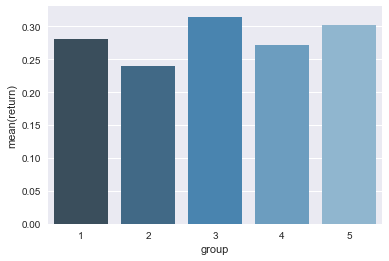

In [129]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")